# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Intro to Dimensionality Reduction and Principal Component Analysis
Week 7 | Lessons 2.1 and 2.2


### LEARNING OBJECTIVES
*After this lesson, you will be able to:*
- Follow the logical workflow behind dimensionality reduction
- Describe the basic intuition of Principal Component Analysis
- Calculate eigenvectors and eigenvalues for use in Principal Component Analysis


### STUDENT PRE-WORK
*Before this lesson, you should already be able to:*
- Have a working understand of scikit learn and numpy
- Be able to create functions from scratch in python
- Have a basic understanding of linear algebra concepts such as matrices

## Introduction: What is Dimensionality Reduction?

Feature selection reduces the number of variables that you are considering for analysis until you are left with the most important features. Out of some total set of variables, or dimensions, we choose some subset. This means we reduce the number of coefficients we need to calculate in, for example, a logistic regression problem. However we lose all information contained in those features we throw away.

Feature transformation is a way to arrive at a similar end-goal, a reduction in the number of dimensions we work with - such as coefficients to be found - but we arrive at this through a linear combination of features that attempts to use information from all the available features rather than discarding some entirely as we do with feature selection. As was the case with feature selection, this can reduce overfitting and can lead to an increase in model performance as well as reduced computational complexity and hence run-time. Additionally dimensionality reduction is often used for the visualisation of high-dimensional feature spaces that are otherwise difficult or impossible to picture. Dimensionality reduction has value in both supervised and unsupervised learning problems.

Imagine we have a linear graph, with one variable on the x axis and another on the y axis. Fitting a line models most of the information in the data (but leaves some noise). We can reduce the dimensions until the 45 degree line is completely horizontal - both of our measurements are now on the same plane - they are *one-dimensional*.

![graph1](./assets/images/graph1.jpg)

![graph2](./assets/images/graph2.jpg)

When we perform feature selection, we choose one of the x axis or the y axis and essentially we are projecting the datapoints onto that axis. We then discard the information from the other axis, or dimension, and retain only that information regarding the axis we chose. In feature transformation used for dimensionality reduction, we are retaining some (though not all) of the information available from both features by projecting onto a new axis. This is generalisable to higher dimensional spaces.


Principal Component Analysis is the method for dimensionality reduction we will focus on, but there are others that you may wish to read further about. 

**Kernel PCA: **
Most straightforwardly, PCA involves only linear transformations and it is possible to generalise the method
to non-linear transformations and this is known as _KernelPCA_.

**Factor analysis: **
This approach works similarly to PCA in its matrix decomposition approach and its assumption of linear combinations of features, though it assumes a Gaussian distribution in the latent features and utilises the correlation matrix rather than the covariance matrix.

**Independent Component Analysis (ICA): **
This approach makes an assumption of independence between the latent features, rather than a lack of correlation as in PCA and factor analysis and assumes non-Gaussian latent features. Its most famous use is in separating audio signals in the _cocktail party problem_ (so clearly independent latent features a priori).

**Linear Discriminant Analysis (LDA): **
This is rather a supervised learning approach (as opposed to the above, which are all unsupervised), which utilises the class labels to provide a dimensionality reduction whilst retaining maximum information on the separation between the classes.

And many others; non-negative matrix factorisation (NMF) assumes data is non-negative (so useful for eg counts as in image analysis), vector quantisation (VQ) involves clustering, archetypal analysis, canonical correlation analysis (CCA)... the list goes on (and you may find some are essentially equivalent).

## When to use dimensionality reduction
- To search for patterns in the data, to find the latent features that describe underlying correlations
- Visualising high dimensional data (particularly useful for visualising clustering)
- To reduce noise, by fitting to the signal and discarding other components
- To reduce computational time and/or optimise algorithm fitting from high dimensional data inputs

In [4]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import numpy as np
import math
from sklearn.preprocessing import StandardScaler

# Some Linear Algebra Review

## Eigenvalues and Eigenvectors

Here we straightforwardly introduce what an eigenvector and corresponding eigenvalue mean, as we will refer to these
in our discussion of principle component analysis (PCA) and implement a solution for PCA involving an eigenvalue
decomposition. If a matrix represents a transformation, its eigenvectors are those vectors which are not affected by the transformation other than to be multiplied by a scalar (because they are perpendicular/parallel to the transformation), the scalar being the eigenvalue that corresponds to that eigenvector (they are always a pair).

In [424]:
# Let us define two vectors u and v, and a matrix A

A=np.array([[3, -2], 
            [1, 0]])
v=np.array([2, 1])
u=np.array([-1, 1])

A_dot_v=A.dot(v)
A_dot_u=A.dot(u)

# dot product of A and v returns (3*2)+(-2*1) = 4 for first value and (1*2)+(0*1) = 2 for second value
# dot product of A and u returns (3*-1)+(-2*1) = -5 for first value and (1*-1)+(0*1) = -1 for second value

print("A dot v is ", A_dot_v)
print("A dot u is ", A_dot_u)

A dot v is  [4 2]
A dot u is  [-5 -1]


But do you notice something interesting? A dot v is actually the same as the scalar value 2 multiplied by v. So by doing a rather complicated looking transformation represented by the matrix A to the vector v, we simply returned a scalar value
multipled by v. This interesting property makes v an eigenvector of A, and makes 2 an eigenvalue. There are likely
to be more such values. How can we find them and what are they useful for? In the context of dimensionality reduction and PCA they represent the principal components, precisely because the eigenvectors are mutually orthogonal and the eigenvalues in that case represent the scaling of the variance along the eigenvector. The formulation to find the eigenvectors and eigenvalues (eigendecomposition) for any matrix is not too difficult, but perhaps a bit beyond the scope of this course. Nevertheless we can have a crack for the simple case and you can read around it if you are keen to know more. I can recommend David Lay's book [_Linear Algebra and its Applications_](http://amzn.eu/6qHf45c). As ever, you can be a competent data scientist without a particularly detailed understanding of what is going on under the hood.

To summarise, essentially one must solve what is known as the characteristic equation of the matrix $A$ which is
$det(A-\lambda I) = 0$. This results in a polynomial with a number of solutions for a square matrix $n\times n$ which is simply $n$. Hence the $2 \times 2$ matrix $A$ we started with will have $2$ eigenvalues and corresponding eigenvectors, and any $n\times n$ matrix will similarly have $n$ eigenvalue/eigenvector pairs.


The main definition: for a matrix $A$, its eigenvectors ($v$) and eigenvalues ($\lambda$) must satisfy $A$$v$ = $\lambda$$v$.

In [426]:
# The determinant of a 2x2 matrix [[a, b], [c, d]] is = ad - bc
# Hence for the case of A we formulate the characteristic equation such that
# determinant(A-lambda I) = 0 
# = det([[3, -2], [1, 0]] - [[lambda, 0], [0, lambda]])
# = (3-lambda)(-lambda) - (-2)
# = (lambda - 1)(lambda - 2) = 0
# Hence solutions are lambda = 2 and lambda = 1
# Then we find the solution for v given Av=v
# As (A-I)v=0
# which gives v2 as the second eigenvector

v_2=np.array([1, 1])
print("Untransformed:")
print(v_2)
print("Transformed:")
print(A.dot(v_2))
print("Eigenvalue in this case is 1")

Untransformed:
[1 1]
Transformed:
[1 1]
Eigenvalue in this case is 1


## Covariance Matrix

Although we actually have been using the covariance matrix before to discuss correlations (or rather, the normalised covariance matrix - which is the correlation matrix), I'll just go through an example of how to calculate it to clarify any mystery. Let's say we have 3 features and 4 training points.

In [272]:
x1=np.array([1,2,1])
x2=np.array([4,2,13])
x3=np.array([7,8,1])
x4=np.array([8,4,5])

# First we calculate the means of each feature in order to centre the data (this is our standard scaling)
x_means=np.mean([x1,x2,x3,x4], axis=0)

x1_centred=x1-x_means
x2_centred=x2-x_means
x3_centred=x3-x_means
x4_centred=x4-x_means
print(x1_centred)
print(x2_centred)
print(x3_centred)
print(x4_centred)

If $B = [x1,  x2,  x3,  x4]$
Then the sample covariance matrix $S = \frac{1}{N-1}BB^T$

In [350]:
# This is the correct form, so each feature is a row
# and each sample is a column
B=np.column_stack([x1_centred,x2_centred,x3_centred,x4_centred])
B

array([[-4., -1.,  2.,  3.],
       [-2., -2.,  4.,  0.],
       [-4.,  8., -4.,  0.]])

In [269]:
# remember this is what the B matrix and its transpose look like
print(B)
print(B.T)

[[-4. -1.  2.  3.]
 [-2. -2.  4.  0.]
 [-4.  8. -4.  0.]]
[[-4. -2. -4.]
 [-1. -2.  8.]
 [ 2.  4. -4.]
 [ 3.  0.  0.]]


In [431]:
# And to find the multiplication of the two you multiply each term in
# the row of the first matrix (B) times its corresponding term in the column
# of the second so eg the first term (=10) would be = (-4*-4) + (-1*-1) + (2*2) + (3*3) = 30, and then * the 1/3 term

# Then the covariance matrix is calculated
S=(1/3)*B.dot(B.T)
S

array([[ 10.,   6.,   0.],
       [  6.,   8.,  -8.],
       [  0.,  -8.,  32.]])

And the interpretation is that each value corresponds to the variance of the feature across the samples
(for the diagonals, since these are the features against themselves) and the covariance of the features
for the corresponding row, column pairs. Note the symmetry in this matrix, this is of course always
the case since e.g. feature 1 is correlated with feature 3 in the same way 3 is correlated with 1.

In [432]:
# We can easily return the variance of each of the three features, which
# matches the diagonals in the covariance matrix seen above

x_var=np.var(np.array([x1_centred,x2_centred,x3_centred,x4_centred]), axis=0, ddof=1)
x_var

array([ 10.,   8.,  32.])

In [433]:
# To return the covariance of any one feature with any other feature
# You can see the analogy to variance; if the features tend to increase (or decrease) together
# then covariance is high (or high in negative), if uncorrelated then they tend to cancel to 0

cov_f1_with_f2=(1/3)*((B[0][0]-np.mean(B[0]))*(B[1][0]-np.mean(B[1]))+(B[0][1]-np.mean(B[0]))*(B[1][1]-np.mean(B[1]))
                +(B[0][2]-np.mean(B[0]))*(B[1][2]-np.mean(B[1]))+(B[0][3]-np.mean(B[0]))*(B[1][3]-np.mean(B[1])))
cov_f1_with_f2

6.0

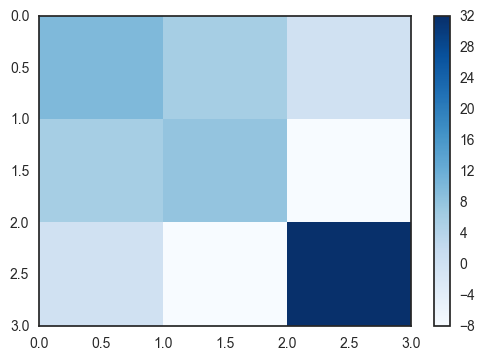

[[ 10.   6.   0.]
 [  6.   8.  -8.]
 [  0.  -8.  32.]]


In [436]:
# Here is a somewhat familiar covariance plot 
# if you did this before using np.corrcoef then you were calculating a normalised
# covariance plot (which is a correlation plot); if we normalise our data beforehand to have 
# variance = 1 we will produce the same result here as that method

plt.pcolor(S, cmap=plt.cm.Blues)
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()
print(S)

## Singular Value Decomposition (SVD)

The formulation to find the eigenvectors and eigenvalues can implement a solution involving an eigendecomposition of the covariance matrix (which is what we will see below), or alternatively it can be found via a singular value
decomposition. Which is used will depend on the computational complexity of either approach (sklearn generally uses an automated method to assess which of the two approaches will be faster). Again, we will not go much into the details
of this but a singular value decomposition of the matrix $X$ would take the form:

$X$ = $U \Sigma V ^ T$

Where $\Sigma$ is a diagonal matrix (containing values only on the diagonal), which contain the eigenvalues (actually the square roots of the eigenvalues) of the covariance matrix of $X$. $U$ contains the left singular vectors (which we do not take) and $V$ the right singular vectors (which are the eigenvectors). Note the SVD has many applications and so its solution is highly optimised computationally via several different algorithmic implementations. It was also used to solve the ordinary least squares regression under the hood. If you are interested I would again refer you to _Linear Algebra and its Applications_.

Ultimately, **this simply means that any matrix satisfying certain conditions can be factorised into three separate matrices**. You do not particularly need to know the details of these things I am mentioning them so you have some idea what the terms mean when you come across them.

In [379]:
# For example, for the matrix X
X=np.array([[4,11,14], [8,7,-2]])
# V is the 3 eigenvectors of the covariance matrix of X in columns
V=np.array([[1/3, -2/3, 2/3], [2/3, -1/3, -2/3], [2/3, 2/3, 1/3]])
# sigma is the square root of the eigenvalues of the covariance matrix of X in a diagonal
sigma=np.array([[(6*np.sqrt(10)), 0, 0], [0, (3*np.sqrt(10)), 0]])
# the columns of U are the normalised vectors obtained from X*eigenvectors
U=np.array([[(3/np.sqrt(10)), (1/np.sqrt(10))], [(1/np.sqrt(10)), (-3/np.sqrt(10))]])
# And hence we see if this factorisation is true
print("Original X: ")
print(A)
print("Factorised:")
print(U.dot(sigma).dot(V.T))

Original X: 
[[ 4 11 14]
 [ 8  7 -2]]
Factorised:
[[  4.  11.  14.]
 [  8.   7.  -2.]]


Hence in general a matrix $X$ can be factorised in this way into $U$, $V$, $\Sigma$ and return the eigenvalues and eigenvectors of its covariance matrix directly, without having to first calculate that covariance matrix.

In [392]:
# To use numpy svd solver
u,s,v=np.linalg.svd(X)
print("V matrix:")
print(v.T)
S = np.zeros((2,3))
S[0,0]=s[0]
S[1,1]=s[1]
print("Sigma matrix:")
print(S)
print("U matrix:")
print(u)
print("Factorised result:")
print(u.dot(S).dot(v))

V matrix:
[[-0.33333333  0.66666667 -0.66666667]
 [-0.66666667  0.33333333  0.66666667]
 [-0.66666667 -0.66666667 -0.33333333]]
Sigma matrix:
[[ 18.97366596   0.           0.        ]
 [  0.           9.48683298   0.        ]]
U matrix:
[[-0.9486833  -0.31622777]
 [-0.31622777  0.9486833 ]]
Factorised result:
[[  4.  11.  14.]
 [  8.   7.  -2.]]


# Principal Component Analysis Overview

PCA is a very popular technique for performing dimensionality reduction. It is the most widely used general technique, which
is why it is wrapped up in this presentation with the whole concept of dimensionality reduction itself.
As we have said, dimensionality reduction is the process of combining or collapsing your existing features (columns in X) 
into new features that not only retain the original information but also ideally reduce noise. PCA finds a linear combinations of your current predictor variables that will create new "principal components" to explain the maximum amount of variance in your predictors. Intuitively, PCA transforms the coordinate system so that the axes become the  most concise, informative descriptors of our data as a whole. The new axes are the principal components.

### The Process of PCA 

Say we have a matrix $X$ of predictor variables. PCA will give us the ability to transform our $X$ matrix into a new matrix $Z$. First we will derive a weighting matrix $W$ from the correlational/covariance structure of $X$ that allows us to perform the transformation. Each successive dimension (column) in $Z$ will be rank-ordered according to the variance in its values.

**There are 3 assumptions that PCA makes:**
1. Linearity: Our data does not hold nonlinear relationships.
2. Large variances define importance: our dimensions are constructed to maximize remaining variance.
3. Principal components are orthogonal: each component (columns of $Z$) is completely un-correlated with the others.

**EIGENVECTORS: ** An eigenvector specifies a direction with respect to the original coordinate space. The eigenvector with the highest correspoding eigenvalue is the first principal component.

**EIGENVALUES: ** Eigenvalues indicate the amount of variance in the direction of the corresponding eigenvector.

Every eigenvector has a corresponding eigenvalue.


### Principal Components

What is a principal component? Principal components are the vectors that define the new coordinate system for your data. Transforming your original data columns onto the principal component axes constructs new variables that are optimized to explain as much variance as possible, and to be independent (uncorrelated). Creating these variables is a well-defined mathematical process, but in essence each component is created as a weighted sum (linear combination) of your original columns, such that all components are orthogonal (perpendicular) to each other.

[Try this out at setosa.io – it's a nice way to explore the intuition](http://setosa.io/ev/principal-component-analysis/)

### Why would we want to do PCA?

- We can reduce the number of dimensions (remove bottom number of components) whilst losing the least possible amount of variance information in our data.
- Since we are assuming our variables are interrelated (at least in the sense that they together explain a dependent variable), the information of interest should exist along directions with largest variance.
- The directions of largest variance should have the highest signal to noise ratio (SNR).
- Correlated predictor variables (also referred to as "redundancy" of information) are combined into independent variables. Our predictors from PCA are guaranteed to be independent, as part of their definition they are orthogonal.

[Paper explaining some more detail on PCA](./assets/papers/PCA-Tutorial-Intuition_jp.pdf)


# Demo: Application of Dimensionality Reduction

Our first priority is to get comfortable with the initial manual workflow of PCA.

- Isolate the feature data
- Center and scale the feature data
- Calculate their covariance matrix
- Calculate the eigenvalues and eigenvectors
- Choose the best n principal components
- Calculate newly extracted feature data

## Guided Practice: Conducting Dimensionality Analysis with PCA in numpy

Let's run through an implementation of PCA. We're going to be revisiting the [wine](./assets/datasets/wine_v.csv) dataset that lists the attributes of various different wine varieties. First we will go through the process in numpy and then with sklearn. The process in numpy will of course take substantially longer and is performed to give a better understanding of the process under the hood.

In [90]:
wine = pd.read_csv('./assets/datasets/wine_v.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Varietal
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Cabernet
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,Cabernet
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,Cabernet
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,Cabernet
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Cabernet


In [120]:
X = wine.ix[:,0:11].values
X_standardised=StandardScaler().fit_transform(X)
y = wine["Varietal"]
y.value_counts()

Merlot        800
Cabernet      230
Cabarnet      199
Malbec        191
Pinot Noir    179
Name: Varietal, dtype: int64

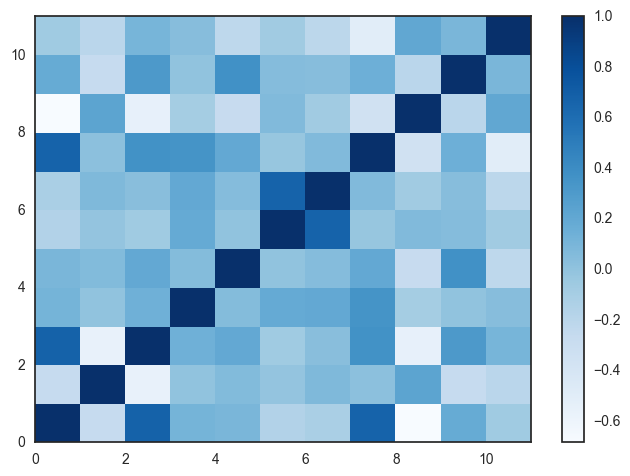

In [121]:
# We calculate the covariance matrix for all of our features, the transposing is a trivial
# step because the numpy function expects our features to be the rows and not the columns
cov_mat = np.cov(X_standardised.T)

# Here is a covariance plot / correlation plot
plt.pcolor(cov_mat, cmap=plt.cm.Blues)
plt.xlim([0,11])
plt.ylim([0,11])
plt.colorbar()
plt.show()

In [122]:
# Now we return the eigenvalues and eigenvectors of that covariance matrix
# Thankfully this very straightforwardly represents our linear transformation
# to new axes represented by these values

eigenValues, eigenVectors = np.linalg.eig(cov_mat)
print("Eigenvalues:")
print(eigenValues)
print("Eigenvectors:")
print(eigenVectors)

Eigenvalues:
[ 3.10107182  1.92711489  1.55151379  1.21399175  0.95989238  0.05959558
  0.18144664  0.34485779  0.42322138  0.58415655  0.66002104]
Eigenvectors:
[[ 0.48931422 -0.11050274 -0.12330157 -0.22961737 -0.08261366 -0.63969145
  -0.24952314  0.19402091 -0.17759545 -0.35022736  0.10147858]
 [-0.23858436  0.27493048 -0.44996253  0.07895978  0.21873452 -0.0023886
   0.36592473 -0.1291103  -0.07877531 -0.5337351   0.41144893]
 [ 0.46363166 -0.15179136  0.23824707 -0.07941826 -0.05857268  0.0709103
   0.62167708 -0.38144967 -0.37751558  0.10549701  0.06959338]
 [ 0.14610715  0.27208024  0.10128338 -0.37279256  0.73214429 -0.18402996
   0.09287208  0.00752295  0.29984469  0.29066341  0.04915555]
 [ 0.21224658  0.14805156 -0.09261383  0.66619476  0.2465009  -0.05306532
  -0.21767112  0.11133867 -0.35700936  0.37041337  0.30433857]
 [-0.03615752  0.51356681  0.42879287 -0.04353782 -0.15915198  0.05142086
   0.24848326  0.63540522 -0.2047805  -0.11659611 -0.01400021]
 [ 0.02357485  0.5

In [123]:
# note that eigenvectors have unit length, they just indicate the direction
# of the principal component
for ev in eigenVectors:
    print(np.sqrt(np.sum(np.square(ev))))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [124]:
# Showing just the first two principal components - eigenvalues and eigenvectors
eig_pairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eig_pairs.sort()
eig_pairs.reverse()
for i in eig_pairs[:2]:
    print(i[0],i[1])

3.10107182268 [ 0.48931422 -0.23858436  0.46363166  0.14610715  0.21224658 -0.03615752
  0.02357485  0.39535301 -0.43851962  0.24292133 -0.11323207]
1.92711488965 [-0.11050274  0.27493048 -0.15179136  0.27208024  0.14805156  0.51356681
  0.56948696  0.23357549  0.00671079 -0.03755392 -0.38618096]


Explained variance tells us how much of the variance has been captured by each principal component. This is implicit in the calculation of the eigenvalue.
$$ ExpVar_i = \bigg(\frac{eigenvalue_i}{\sum_j^n{eigenvalue_j}}\bigg) \times 100$$

In [125]:
# Explained variance as a ratio of the total
# because eigenvalues describe the variance in each principal component
# so by summing them we get the total variance

eigenValues/sum(eigenValues)

array([ 0.28173931,  0.1750827 ,  0.1409585 ,  0.11029387,  0.08720837,
        0.00541439,  0.01648483,  0.0313311 ,  0.03845061,  0.05307193,
        0.05996439])

In [126]:
# Can also see this in a cumulative way
tot = sum(eigenValues)
var_exp = [(i / tot)*100 for i in sorted(eigenValues, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([  28.17393128,   45.68220118,   59.77805108,   70.80743772,
         79.52827474,   85.52471351,   90.83190641,   94.67696732,
         97.81007747,   99.4585608 ,  100.        ])

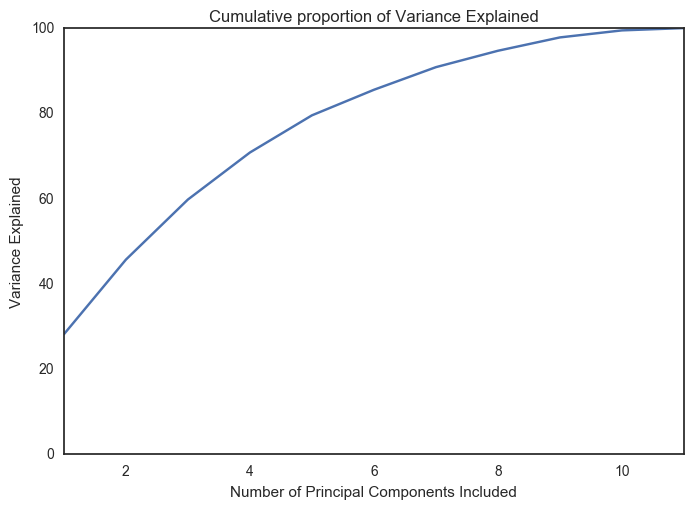

In [127]:
# And we can plot this
plt.plot(range(1,12), list(cum_var_exp))
plt.xlim([1,11])
plt.ylim([0,100])
plt.title("Cumulative proportion of Variance Explained")
plt.ylabel("Variance Explained")
plt.xlabel("Number of Principal Components Included")
plt.show()

In [128]:
# We can use this to transform our data onto a lower dimension space with eg only two features (45% variance explained)
# eig_pairs[0][1] just returns the first principal component eigenvector
# and eig_pairs[1][1] returns the second principal component eigenvector (slightly awkward notation a result
# of having to sort the eigenvalues to return the eigenvectors in the order of interest)
# np.hstack() just a function for constructing an array, this forms our transformation matrix
W = np.hstack((eig_pairs[0][1].reshape(11,1), eig_pairs[1][1].reshape(11,1)))
W

array([[ 0.48931422, -0.11050274],
       [-0.23858436,  0.27493048],
       [ 0.46363166, -0.15179136],
       [ 0.14610715,  0.27208024],
       [ 0.21224658,  0.14805156],
       [-0.03615752,  0.51356681],
       [ 0.02357485,  0.56948696],
       [ 0.39535301,  0.23357549],
       [-0.43851962,  0.00671079],
       [ 0.24292133, -0.03755392],
       [-0.11323207, -0.38618096]])

In [129]:
# Note that the eigenvectors are mutually orthogonal, which you can test by
# finding their dot product, which remember returns |A||B|cos(theta) where theta is the angle
# between the vectors. We know |A| & |B| are both 1, so if theta is 90 then cos(theta) = 0
# and hence the dot product is zero (here it is very close to zero owing to rounding)
# Note that this is generally true - all the eigenvectors are mutually orthogonal (remember - this is a multi
# dimensional space!)

W[:,0].dot(W[:,1])

-1.6653345369377348e-16

In [133]:
# Forming the dot product between our matrix of values and the transformation
# in order to produce the transformed features
X_reduced = X_standardised.dot(W)

# New two-feature values
X_reduced

array([[-1.61952988,  0.45095009],
       [-0.79916993,  1.85655306],
       [-0.74847909,  0.88203886],
       ..., 
       [-1.45612897,  0.31174559],
       [-2.27051793,  0.97979111],
       [-0.42697475, -0.53669021]])

In [131]:
cov_mat_reduced = np.cov(X_reduced.T)

# In the new transformed coordinate system, the covariance matrix is diagonal
# i.e. values of zero for the covariance of features with
# each other (only returning variance of features with themselves)
# (again note very low values effectively zero owing to rounding)
print(cov_mat_reduced)

[[  3.10107182e+00  -6.28061085e-16]
 [ -6.28061085e-16   1.92711489e+00]]


In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Now we can run a classifier based on our original features, and again using our new transformed features

X_train, X_test, y_train, y_test = train_test_split(X_standardised, y, test_size=0.2, random_state=1)
clf = RandomForestClassifier(random_state=1)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test), "accuracy, using {0} dimensions.".format(X_standardised.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=1)
clf = RandomForestClassifier(random_state=1)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test), "accuracy, using {0} principal component dimensions.".format(X_reduced.shape[1]))

0.61875 accuracy, using 11 dimensions.
0.525 accuracy, using 2 principal component dimensions.


So with only 45% of the variance explained from the two selected new features, we still have around 53% accuracy compared to 62% when we used 11 original features. That's pretty good, and we could of course use more of the
principal components to get that score higher by using more of the explained variance. You can play around with that to see what you get (that's easier to do with the sklearn example below though).

## Guided Practice: Conducting Dimensionality Analysis with PCA in sklearn

In [76]:
# Simply repeat that process from the start, but using sklearn

wine = pd.read_csv('./assets/datasets/wine_v.csv')
X = wine.ix[:,0:11].values
X_standardised = StandardScaler().fit_transform(X)
y = wine["Varietal"]

In [77]:
from sklearn.decomposition import PCA

# select n_components for the number of principal components you wish to use
pca = PCA(n_components=2)

pca.fit(X_standardised)
print("--")
print("The eigenvalues give the relative explained variance of each principal components:", pca.explained_variance_)
print("--")
print("This value as a ratio of the total variance:", pca.explained_variance_ratio_)
print("--")
print("The two vectors describing the principal components:")
print(pca.components_)
print("--")

--
The eigenvalues give the relative explained variance of each principal components: [ 3.09913244  1.92590969]
--
This value as a ratio of the total variance: [ 0.28173931  0.1750827 ]
--
The two vectors describing the principal components:
[[ 0.48931422 -0.23858436  0.46363166  0.14610715  0.21224658 -0.03615752
   0.02357485  0.39535301 -0.43851962  0.24292133 -0.11323207]
 [-0.11050274  0.27493048 -0.15179136  0.27208024  0.14805156  0.51356681
   0.56948696  0.23357549  0.00671079 -0.03755392 -0.38618096]]
--


In [78]:
# Have to transform the data from the pca to return the reduced dataset
# Try changing the n_components in the cell above and see how the accuracy changes
X_reduced=pca.transform(X_standardised)

# Perform the same model fits as before
X_train, X_test, y_train, y_test = train_test_split(X_standardised, y, test_size=0.2, random_state=1)
clf = RandomForestClassifier(random_state=1)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test), "accuracy, using {0} dimensions.".format(X_standardised.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=1)
clf = RandomForestClassifier(random_state=1)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test), "accuracy, using {0} principal component dimensions.".format(X_reduced.shape[1]))

0.61875 accuracy, using 11 dimensions.
0.525 accuracy, using 2 principal component dimensions.


So we got the same results as the manual approach, and this of course is how we would do it normally. But PCA is
an approach that has a bit more abstraction than others so it's good to dive in and see what is going on at least
a few times to get it clear.

## Recap
- Recap and recall the process steps in dimensionality reduction
    -  Covariance Matrix: First, we create a covariance matrix to decompose so that we may find our eigenvalues / eigenvectors. 
    -  Eigenvectors & Eigenvalues: We decompose the covariance matrix to derive our eigenvectors and eigenvalues, and select the top  combined eigenpairs (corresponding eigenvalues and eigenvectors) to become our principal components.
    -  Lastly, we project the eigenpairs onto a new feature subspace.


## Manual PCA Codealong and Further Discussion


**MANUAL PCA STEPS:**

1. Standardize data: centering is required, but full normalization is nice for visuals later.
2. Calculate eigenvectors and eigenvalues from correlation or covariance matrix.
3. Sort eigenvalues and choose eigenvectors that correspond to the largest eigenvalues. The number you choose is up to you, but we will take 2 for the sake of visualization here.
4. Construct the projection weighting matrix $W$ from the eigenvectors.
5. Transform the original dataset $X$ with $W$ to obtain the new 2-dimensional transformed matrix $Z$.



**DATA**

We are going to be using a simple 75-row, 4-column dataset with demographic information. It contains:

    age (limited to 20-65)
    income
    health (a rating on a scale of 1-100, where 100 is the best health)
    stress (a rating on a scale of 1-100, where 100 is the most stressed)
    
All of the variables are continuous.



In [84]:
import seaborn as sns

sns.set_style('white')

# We have age, income, health, and stress
# this is unsupervised learning: we are looking for relationships in
# the data, not to predict an outcome
demo = pd.read_csv('./assets/datasets/simple_demographics.csv')

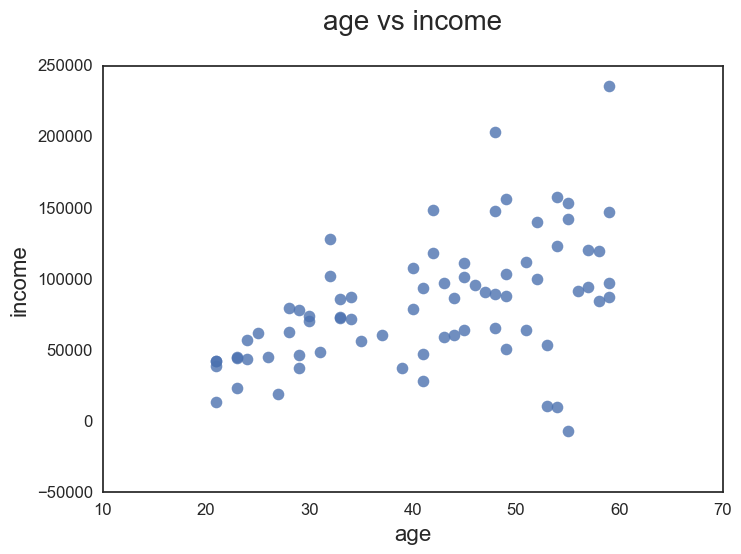

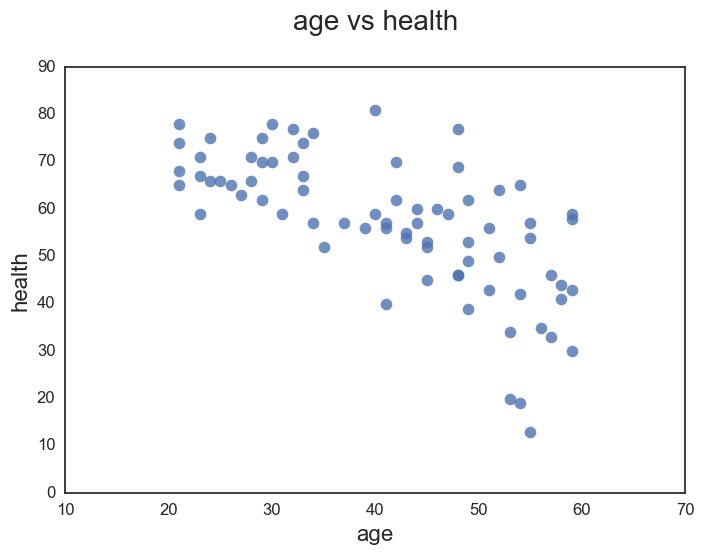

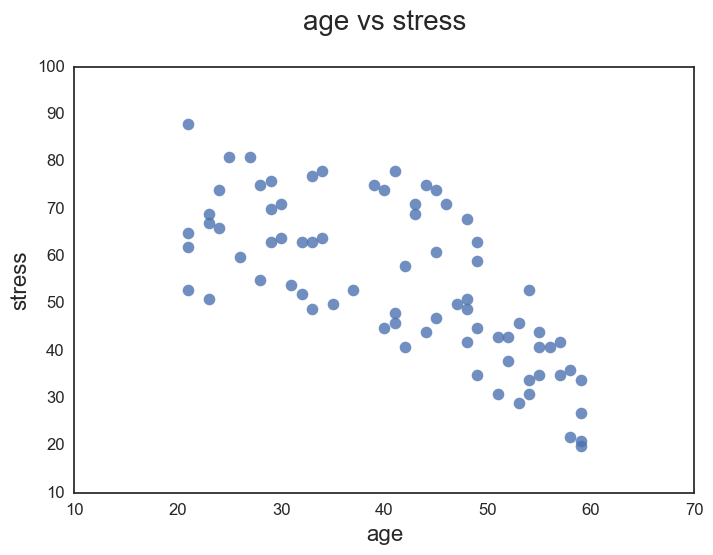

In [19]:
# We will start with some EDA by looking for correlations manually

# age vs income
fig = plt.figure()
ax = fig.gca()
ax = sns.regplot('age', 'income', data=demo, fit_reg=False, scatter_kws={'s':70}, ax=ax)
ax.set_ylabel('income', fontsize=16)
ax.set_xlabel('age', fontsize=16)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)   
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)   
ax.set_title('age vs income\n', fontsize=20)
plt.show()

# age vs health
fig = plt.figure()
ax = fig.gca()
ax = sns.regplot('age', 'health', data=demo, fit_reg=False, scatter_kws={'s':70}, ax=ax)
ax.set_ylabel('health', fontsize=16)
ax.set_xlabel('age', fontsize=16)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)   
ax.set_title('age vs health\n', fontsize=20)
plt.show()

# age vs stress
fig = plt.figure()
ax = fig.gca()
ax = sns.regplot('age', 'stress', data=demo, fit_reg=False, scatter_kws={'s':70}, ax=ax)
ax.set_ylabel('stress', fontsize=16)
ax.set_xlabel('age', fontsize=16)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)   
ax.set_title('age vs stress\n', fontsize=20)
plt.show()

**Check:** What does this mean?

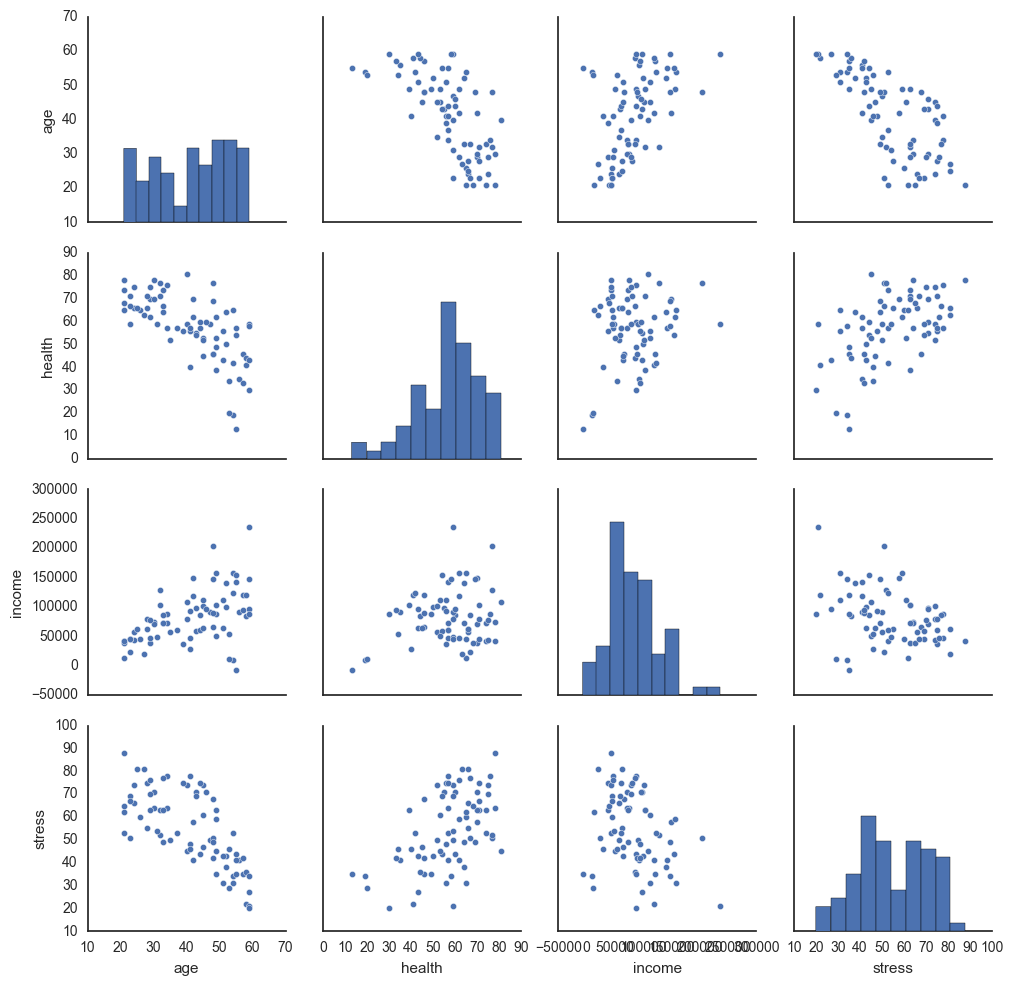

In [31]:
# Pairplot gives us a nice summary of all variables against each other
# this can get impractical for large numbers of features, eg with text data

sns.pairplot(demo)
plt.show()

### 2. Normalise


In [138]:
demo_normed = pd.DataFrame(data=StandardScaler().fit_transform(demo), columns=demo.columns)
demo_normed.head()

,age,health,income,stress
0,-1.713067,1.170996,-0.900920,-0.084764
1,-0.697415,0.476180,-0.220986,-0.329274
2,-0.951328,1.448922,-0.189621,0.587640
3,-0.782052,0.962551,0.452385,0.526513
4,1.333890,-0.774488,0.856779,-1.185061


### 3. Calculate correlation matrix

We will be using the correlation matrix to calculate the eigenvectors and eigenvalues.

In [139]:
demo_corr = np.corrcoef(demo_normed.values.T)
demo.corr()

,age,health,income,stress
age,1.000000,-0.674142,0.503590,-0.713347
health,-0.674142,1.000000,0.192037,0.527663
income,0.503590,0.192037,1.000000,-0.347925
stress,-0.713347,0.527663,-0.347925,1.000000


### 4. Calculate the eigenvalues and eigenvectors from the correlation matrix

numpy has a convenient function to calculate this:

    eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)

In [140]:
eig_vals, eig_vecs = np.linalg.eig(demo_corr)
print("Eigenvalues:")
print(eig_vals)
print("Eigenvectors:")
print(eig_vecs)

Eigenvalues:
[ 2.40364849  0.05984905  0.3528844   1.18361806]
Eigenvectors:
[[ 0.61576888 -0.67362516 -0.40503549 -0.05480943]
 [-0.46635572 -0.56948936  0.31893332 -0.5970559 ]
 [ 0.29634945  0.47075742 -0.224109   -0.80021223]
 [-0.56170992 -0.01727598 -0.8270447   0.01343761]]


### 4. Calculate and plot the explained variance

A useful measure is the **explained variance**, which is calculated from the eigenvalues. The explained variance tells us how much information (variance) is captured by each principal component.


In [141]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative explained variance:")
print(cum_var_exp)

Cumulative explained variance:
[  60.09121236   89.68166379   98.50377378  100.        ]


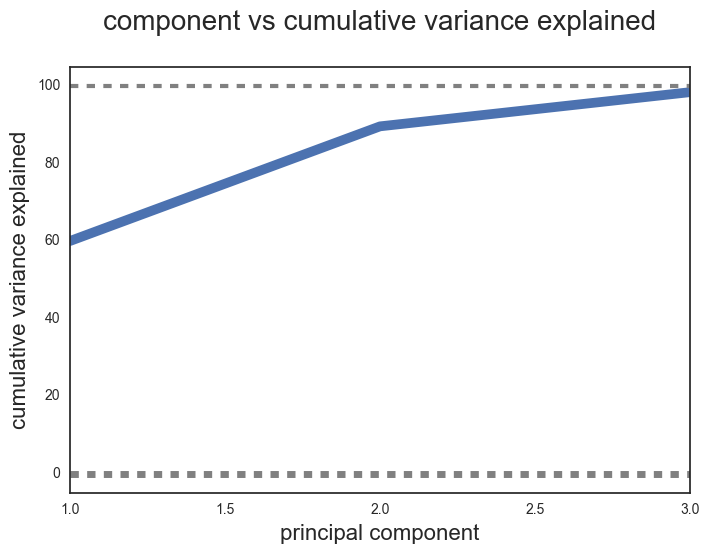

In [142]:
plt.plot([1,2,3,4], cum_var_exp, lw=7)
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')
ax = plt.gca()
ax.set_xlim([1,3])
ax.set_ylim([-5,105])
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('principal component', fontsize=16) 
ax.set_title('component vs cumulative variance explained\n', fontsize=20)
plt.show()

### 5. Construct the Projection Matrix $W$

This is simply a matrix of our top 2 eigenvectors. The eigenvectors are concatenated as columns.

1. Start by ordering the eigenvectors by their corresponding eigenvalues biggest to smallest.
- Concatenate the eigenvectors together. `np.hstack()` is useful for this.


In [143]:
value_vector_pairs = [[eig_vals[i], eig_vecs[:,i]] for i in range(len(eig_vals))]
value_vector_pairs.sort(reverse=True)

In [144]:
weight_2d_projection = np.hstack((value_vector_pairs[0][1].reshape(eig_vecs.shape[1],1),
                                  value_vector_pairs[1][1].reshape(eig_vecs.shape[1],1)))
print('Weight data 2d PCA projection matrix:\n', weight_2d_projection)

Weight data 2d PCA projection matrix:
 [[ 0.61576888 -0.05480943]
 [-0.46635572 -0.5970559 ]
 [ 0.29634945 -0.80021223]
 [-0.56170992  0.01343761]]


**Check** the projection matrix represents what?

### 6. Construct the Transformed 2D Matrix $Z$

To do this, we take the dot product of our 3D demographic matrix $X$ with the projection matrix $W$

In [145]:
Z = demo_normed.dot(weight_2d_projection)

### 7. Plot Principal Component 1 vs 2

PC1 is the first column in $Z$, and PC2 is the second.

Notice how they are un-correlated.

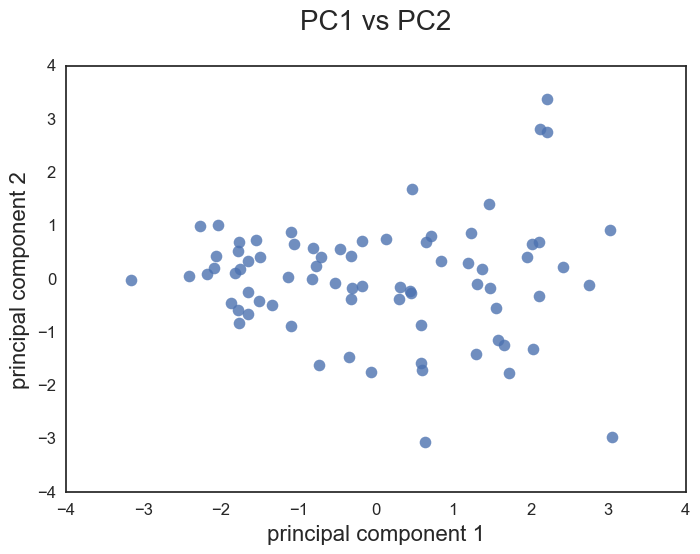

In [146]:
# Here we are plotting our transformed data on our new 2 dimensional feature space
# note we couldn't plot the 4 dimensional data on one plot before, we had to plot
# each feature against each other feature

fig = plt.figure()
ax = fig.gca()
ax = sns.regplot(Z.iloc[:,0], Z.iloc[:,1],
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)
ax.set_xlabel('principal component 1', fontsize=16)
ax.set_ylabel('principal component 2', fontsize=16)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)   
ax.set_title('PC1 vs PC2\n', fontsize=20)
plt.show()

### 9. Concatenate PC1 and PC2 to the full demographic (4D) dataset, then melt it with PC1 and PC2 and index variables


In [147]:
demo_normed['PC1'] = Z.iloc[:,0]
demo_normed['PC2'] = Z.iloc[:,1]
demo2 = pd.melt(demo_normed, id_vars=['PC1','PC2'])
demo_normed.head()

,age,health,income,stress,PC1,PC2
0,-1.713067,1.170996,-0.900920,-0.084764,-1.820329,0.114530
1,-0.697415,0.476180,-0.220986,-0.329274,-0.532048,-0.073670
2,-0.951328,1.448922,-0.189621,0.587640,-1.647789,-0.653312
3,-0.782052,0.962551,0.452385,0.526513,-1.092138,-0.886762
4,1.333890,-0.774488,0.856779,-1.185061,2.102122,-0.312226


In [148]:
# Just so you can see what that did, made a long form version of the dataset for plotting
demo2.head()

,PC1,PC2,variable,value
0,-1.820329,0.114530,age,-1.713067
1,-0.532048,-0.073670,age,-0.697415
2,-1.647789,-0.653312,age,-0.951328
3,-1.092138,-0.886762,age,-0.782052
4,2.102122,-0.312226,age,1.333890


### 10. Use lmplot to check out PC1 vs all 4 variables


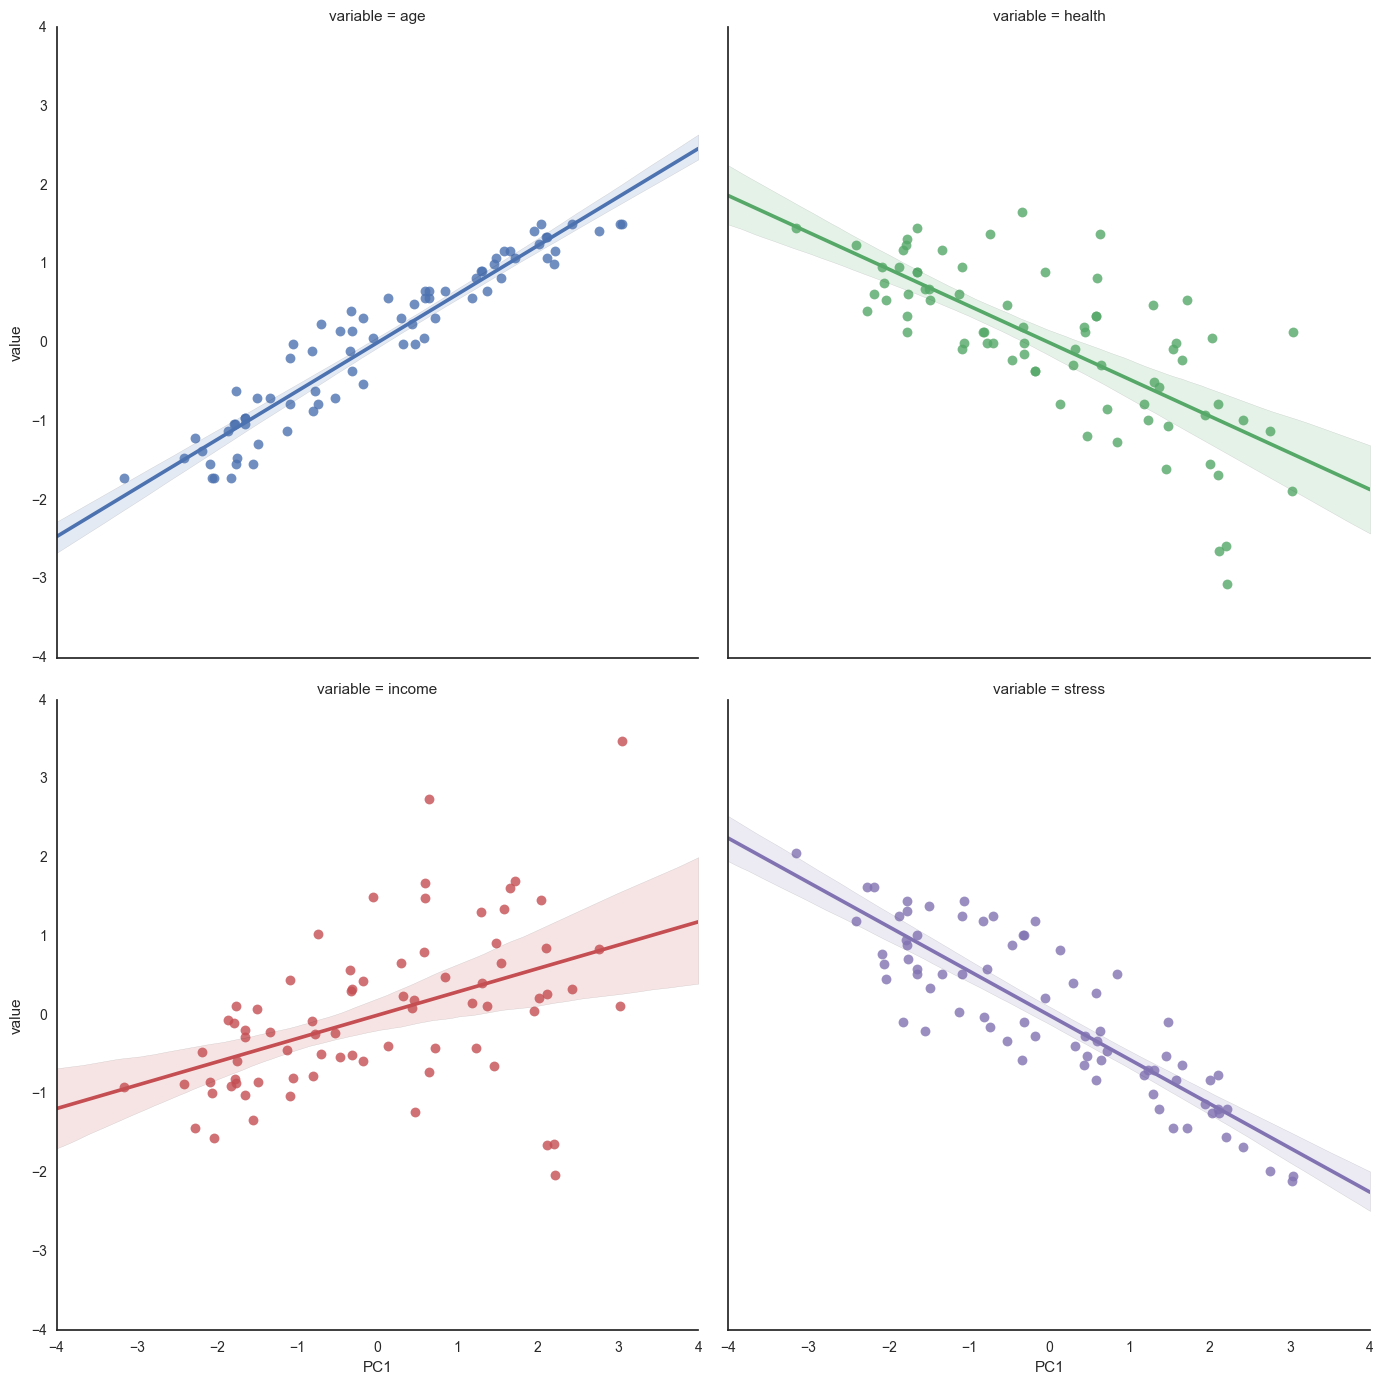

In [149]:
# Plots are principal component 1 on the x axis and different variables on the y
sns.lmplot(x="PC1", y="value", col="variable", hue="variable", 
                 data=demo2, col_wrap=2, size=7, scatter_kws={'s':50})
plt.show()

### 11. Use lmplot to do the same for PC2

Notice how PC2 captures the variance of income, which was not captured well by PC1. This makes sense, as the variance each principal component captures has to be orthogonal to the other components. We saw before that age vs stress and age vs health had a distinct relationship to age vs income.

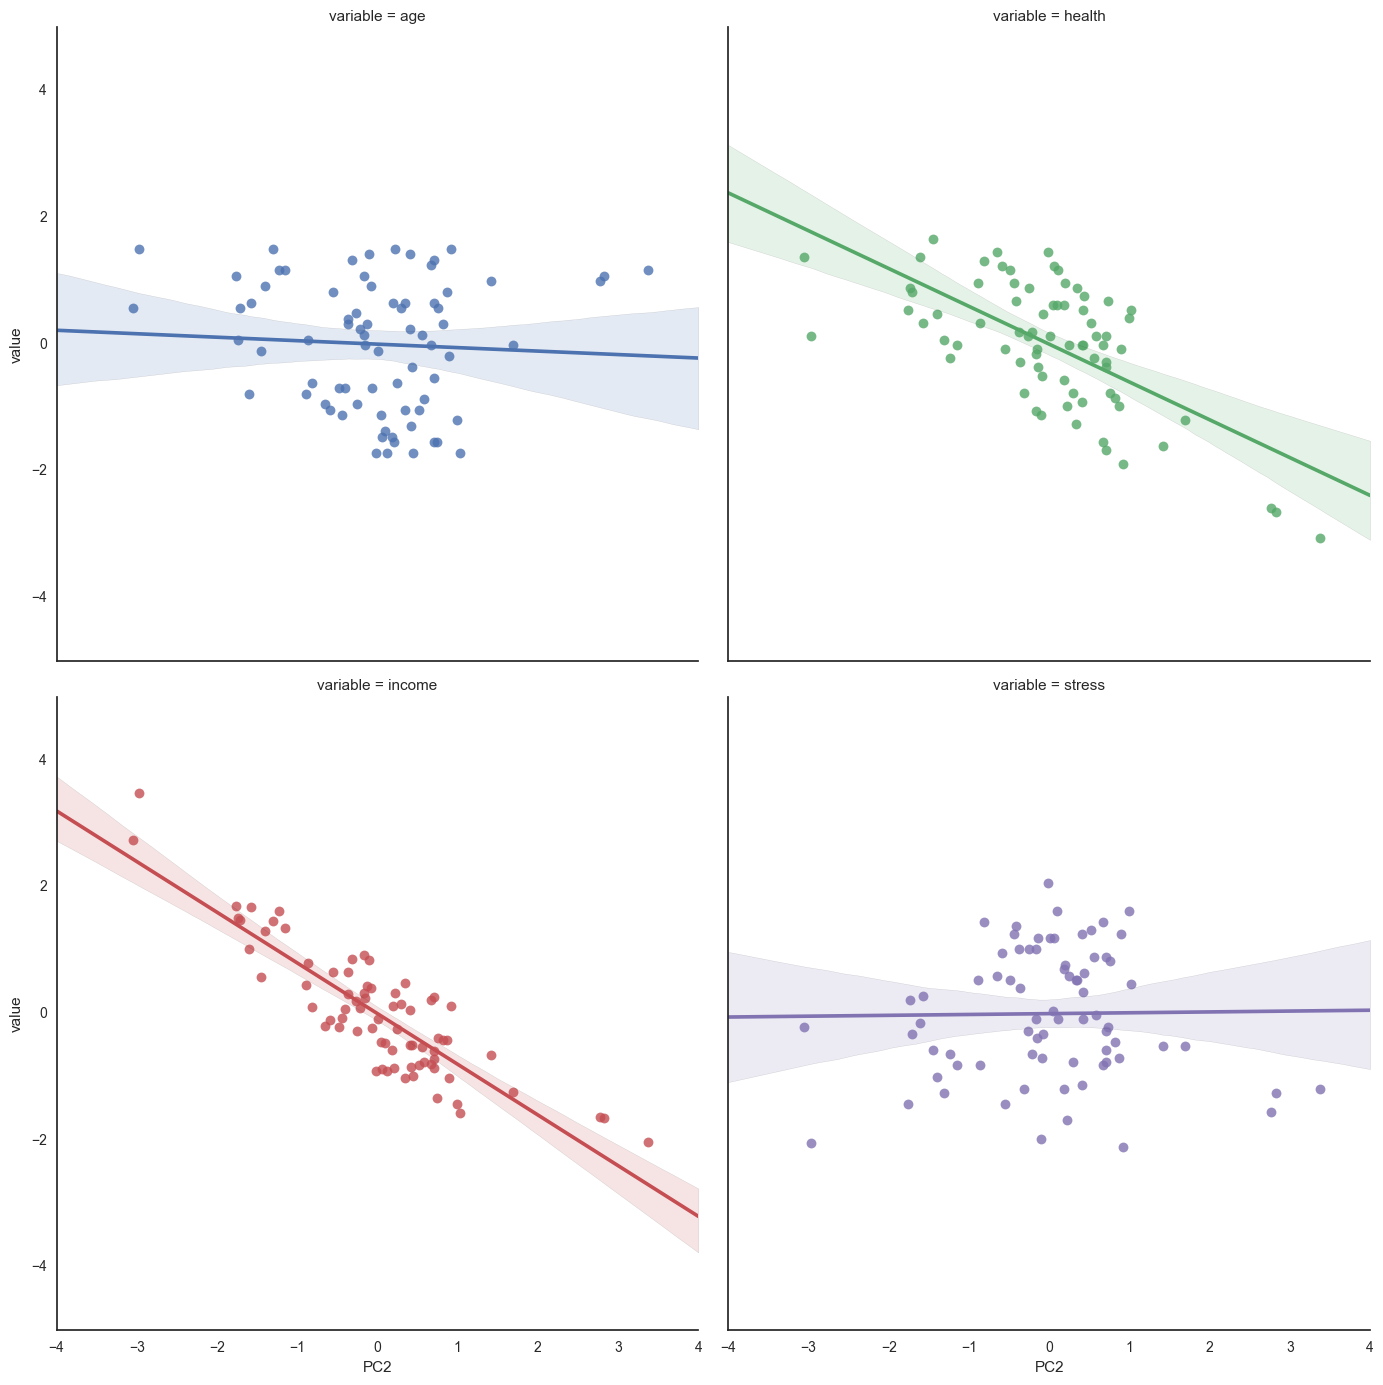

In [150]:
sns.lmplot(x="PC2", y="value", col="variable", hue="variable", 
                 data=demo2, col_wrap=2, size=7, scatter_kws={'s':50})
plt.show()

# Final Words - Simplified PCA

I was asked to provide a relatable interpretation of PCA for the non data scientist, to be used for example when dealing with non-technical stakeholders. In general that is something I hope you can all do, if not right now then in some time when you have absorbed this information. This is indeed a good task to check for understanding and something you can use blog posts to get some practice at. Here is how I would put it - underlying your many features in the data, we hypothesise that that are some latent features that describe most of what is going on. We believe that, for example, time spent on a website and number of clicks and number of pages viewed all represent some underlying feature which we might term "user engagement". We can hence transform our data to create a smaller number of new features that retain most of the information from multiple different features and hence simplify it. 

In PCA, we achieve this by linearly combining the features to create a new one, so eg one unit of this one, two of that one and so on. This creates a new feature which is a principal component and combines information from all features together in varying degrees. The next principle component will take more of another feature and less of a different one. We then select how many principal components to take. If we take all of them, we have simply performed a transformation of our data onto a new co-ordinate system that will change nothing in the underlying data. However due to the nature of the transformation we can actually remove many of the principal components and still retain most of the information available in the data (which we measured as the variance).

The result should be something computationally easier to handle, easier to visualise, something that reveals underlying structures and patterns and correlations in our data, and furthermore something that can help reduce noise and overfitting when we fit a model to the transformed data.